# Trend Prediction by LSTM Neutral Network

This notebook focused on using TensorFlow LSTM for studying time series. The idea comes from some examples I found in the internet. This will be the first of a sequence in my exploration of LSTM. In this exercise, I will try to model the univariate time series of the flight passenger on a flight company by building it from scratch.  

Written by Shing Chi Leung at 30 January 2021

First import the necessary libraries and mount the drive to access the datafile

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import numpy as np
import math

In [ ]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


# 1. Data Preparation

Read the file using the defined path and output the raw numerical data

In [ ]:
file_path = "gdrive/MyDrive/Colab Notebooks/airline-passengers.csv"

def read_file(file_path):

  raw_data = []
  with open(file_path,"r") as f:
    f.readline()  
    for line in f.readlines():
      split_line = line.strip().split(",")
      raw_data.append(int(split_line[1]))

    return np.array(raw_data)

raw_data = read_file(file_path)
print(raw_data[:3])


[112 118 132]


Then, normalize the data into a range of (0,1) so that it can work well with the neural network. 

In [ ]:
def normalize_data(raw_data):

  raw_data = np.array(raw_data).reshape(raw_data.shape[0],-1)

  scaler = MinMaxScaler()
  scaler.fit(raw_data)
  scaled_data = scaler.transform(raw_data)

  return scaled_data, scaler 

scaled_data, scaler = normalize_data(raw_data)
print(scaled_data[:3])

[[0.01544402]
 [0.02702703]
 [0.05405405]]


Process the scaled data to make it into timeslices, and then split them into train and test

In [ ]:
lookback = 3
test_ratio = 0.2

def create_train_test_data(raw_data, lookback, test_ratio):

  print("reading raw data of size: {}".format(len(raw_data)))

  source = []
  target = []
  for i in range(lookback, len(raw_data)-1):
    source.append(raw_data[i-lookback:i])
    target.append(raw_data[i])

  x_train, x_test, y_train, y_test = train_test_split(source, target, test_size=test_ratio, shuffle=False)

  # convert the list into np.array
  x_train = np.array(x_train)
  x_test = np.array(x_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  # Reshape the array for LSTM use
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
  x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = create_train_test_data(scaled_data, lookback, test_ratio)
print("shape of x_train: {}".format(x_train.shape))
print("shape of x_test: {}".format(x_test.shape))

print("sample data in x_train: {}".format(x_train[:3]))
print("sample data in y_train: {}".format(y_train[:3]))

reading raw data of size: 144
shape of x_train: (112, 3, 1)
shape of x_test: (28, 3, 1)
sample data in x_train: [[[0.01544402]
  [0.02702703]
  [0.05405405]]

 [[0.02702703]
  [0.05405405]
  [0.04826255]]

 [[0.05405405]
  [0.04826255]
  [0.03281853]]]
sample data in y_train: [[0.04826255]
 [0.03281853]
 [0.05984556]]


# 2. Neural Network Construction and Training

Build the model using LSTM and Dense layers

In [ ]:
def build_model(input_shape):

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.LSTM(6, input_shape=input_shape))
  model.add(tf.keras.layers.Dense(1))

  return model

print("input shpe = ", x_train[0].shape)
model = build_model(x_train[0].shape)
model.summary()


input shpe =  (3, 1)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


Compile and train the model using the standard prescription

In [ ]:
def compile_model(model):

  optimizer = "adam"
  loss = "mse"
  metrics = ["accuracy"]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

compile_model(model)

In [ ]:
def train_model(model, x_train, y_train):

  history = model.fit(x_train, y_train, epochs=100, verbose=0, batch_size=1, validation_split=0.2)
  return history 

history = train_model(model, x_train, y_train)
#print(history.history["accuracy"][-1])

Use the trained model to predict, and scale back to the original numerical scale for comparison

In [ ]:
y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

# rescale the prediction data
y_train_predict = scaler.inverse_transform(y_train_predict)
y_test_predict = scaler.inverse_transform(y_test_predict)

train_score = math.sqrt(mean_squared_error(y_train, y_train_predict))
test_score = math.sqrt(mean_squared_error(y_test, y_test_predict))

print("train score: {}".format(train_score))
print("test score: {}".format(test_score))

train score: 247.7078490042649
test score: 431.84975447225554


# 3. Model Prediction and Visualization

Plot the predicted data and the original data to see how good/bad the LSTM network does

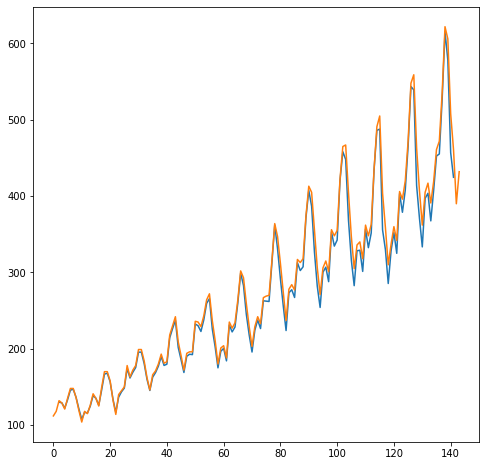

In [ ]:
prediction = np.concatenate((y_train_predict, y_test_predict), axis=0)
shifted_date = np.array([i for i in range(lookback-1, len(raw_data)-2)])
fig, ax = plt.subplots(figsize=(8,8), ncols=1, nrows=1)
ax.plot(shifted_date, prediction)
ax.plot(np.array(raw_data))

To my surprise, using just a few neurons can already suffice to make an acceptable predict (to the bare-eye level). In early time, where the range of data is small, the model can reproduce almost accurately the real data. However, when the amplitude increases, the transition points (the places where the curve switches its direction) has a larger discrepency. 